In [1]:
import numpy as np
import math
import cv2
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.text as mtext

from skimage.measure import label, regionprops

%matplotlib inline

In [2]:
frame = np.load('../images/sample-1.npy')

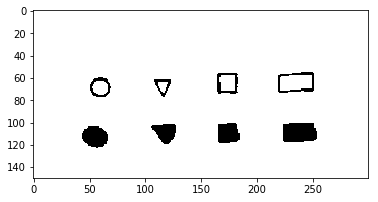

In [3]:
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)[0:150, 0:300]
threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1] / 255

plt.imshow(threshold, cmap='gray')

labeled 8 regions


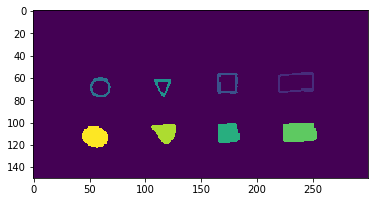

In [4]:
labeled_image = label(threshold[0:150, 0:300], background=1)
print 'labeled {} regions'.format(labeled_image.max())
plt.imshow(labeled_image, vmin=labeled_image.min(), vmax=labeled_image.max())

In [5]:
regions =  regionprops(labeled_image)

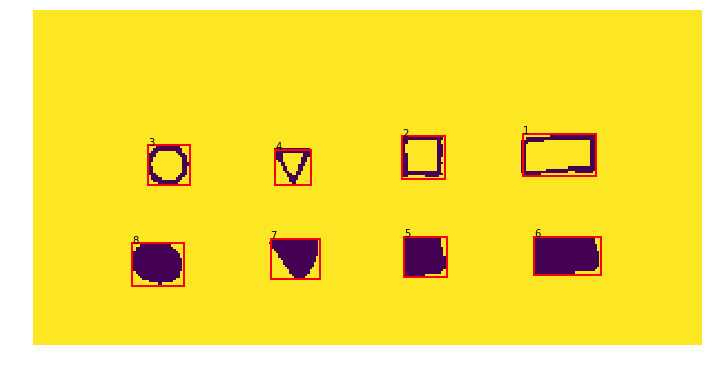

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(threshold)

for region in regions:
    minr, minc, maxr, maxc = region.bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    ax.annotate('{}'.format(region.label), (minc, minr))

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [7]:
LABELS = {
    1: 'rectangle_slot',
    2: 'square_slot',
    3: 'circle_slot',
    4: 'triangle_slot',
    5: 'square_block',
    6: 'rectangle_block',
    7: 'triangle_block',
    8: 'circle_block'
}

def parse_region(region):
    return {
        'area': region.area,
        'orientation': region.orientation,
        'perimeter': region.perimeter,
        'minor_axis': region.minor_axis_length,
        'major_axis': region.major_axis_length,
        'convex_area': region.convex_area,
        'filled_area': region.filled_area, 
        'solidity': region.solidity,
        'image': region.image,
        'eccentricity': region.eccentricity
    }
    

region_stats = pd.DataFrame()
for r in regions:
    region = parse_region(r)
    region['label'] = LABELS[int(r.label)]
    region_stats = region_stats.append(region, ignore_index=True)

region_stats

/home/nikhil/.local/lib/python2.7/site-packages/skimage/measure/_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
/home/nikhil/.local/lib/python2.7/site-packages/skimage/measure/_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)


,area,convex_area,eccentricity,filled_area,image,label,major_axis,minor_axis,orientation,perimeter,solidity
0,194.0,586.0,0.813325,561.0,"[[False, False, False, False, False, False, Fa...",rectangle_slot,45.833759,26.666505,0.094125,163.692388,0.331058
1,153.0,355.0,0.252006,339.0,"[[False, True, True, True, True, True, True, T...",square_slot,26.813371,25.947988,0.058304,116.142136,0.430986
2,122.0,276.0,0.209648,270.0,"[[False, False, False, False, False, False, Fa...",circle_slot,23.313617,22.795519,0.528066,75.627417,0.442029
3,94.0,161.0,0.411033,156.0,"[[True, True, True, True, True, True, True, Tr...",triangle_slot,18.884162,17.215186,-1.196367,78.763456,0.583851
4,306.0,317.0,0.358354,306.0,"[[False, False, False, False, False, False, Fa...",square_block,20.758910,19.380223,0.155052,65.313708,0.965300
5,479.0,488.0,0.824735,479.0,"[[False, False, False, False, False, True, Tru...",rectangle_block,33.307525,18.836044,0.028858,85.899495,0.981557
6,269.0,279.0,0.510743,269.0,"[[False, False, False, False, False, False, Fa...",triangle_block,20.873894,17.945988,-0.406693,64.284271,0.964158
7,343.0,354.0,0.619763,343.0,"[[False, False, False, False, False, True, Tru...",circle_block,23.596829,18.518534,-0.256290,67.698485,0.968927


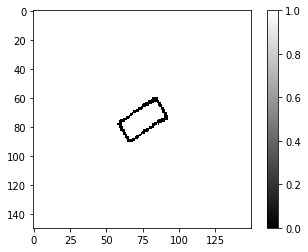

In [8]:
def rotate_scale_image(mat, angle, scale):
    height, width = mat.shape[:2]
    image_center = (width / 2, height / 2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1)

    radians = math.radians(angle)
    sin = math.sin(radians)
    cos = math.cos(radians)
    bound_w = int((height * abs(sin)) + (width * abs(cos)))
    bound_h = int((height * abs(cos)) + (width * abs(sin)))

    rotation_mat[0, 2] += ((bound_w / 2) - image_center[0])
    rotation_mat[1, 2] += ((bound_h / 2) - image_center[1])

    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    scale += 1
    rotated_mat = cv2.resize(rotated_mat, (0,0), fx=scale, fy=scale) 
   
    horizontal_padding = (150 - rotated_mat.shape[0]) / 2
    vertical_padding = (150 - rotated_mat.shape[1])/2
        
    rotated_mat = cv2.copyMakeBorder(rotated_mat, horizontal_padding, horizontal_padding, vertical_padding, vertical_padding, cv2.BORDER_CONSTANT, value=0)
    rotated_mat = np.abs(1 - rotated_mat)

    return rotated_mat 
    
plt.imshow(rotate_scale_image(region_stats.iloc[0]['image'].astype(np.uint8), 30, -0.01), cmap='gray')
plt.colorbar()
plt.show()

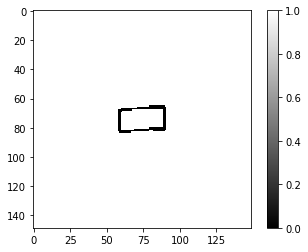

In [9]:
plt.imshow(rotate_scale_image(region_stats.iloc[0]['image'].astype(np.uint8), 0, -0.01), cmap='gray')
plt.colorbar()
plt.show()

# Randomize Rotation and Scale

In [10]:
training_set = pd.DataFrame()

def rotate_and_parse_region(image, angle, scale):
    image = rotate_scale_image(image, angle, scale)
    labels = label(image, background=1)
    region = regionprops(labels)
    if len(region) != 1:
        raise
    return parse_region(region[0])
    

for index, region in region_stats.iterrows():
    for angle in range(0, 180):
        angle *= 2
        scale = 0.05 - 0.025*np.random.rand()
        try:
            r = rotate_and_parse_region(region['image'].astype(np.uint8), angle, scale)
        except:
            continue
        r['label'] = region.label
        r['angle'] = angle
        r['scale'] = scale
        r.pop('image', None)
        
        training_set = training_set.append(r, ignore_index=True)


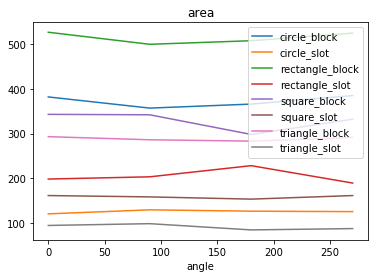

In [61]:
def plot_feature(feature):
    t = training_set.set_index('angle')
    t.groupby('label')[feature].plot(legend=True, title=feature)

plot_feature('area')

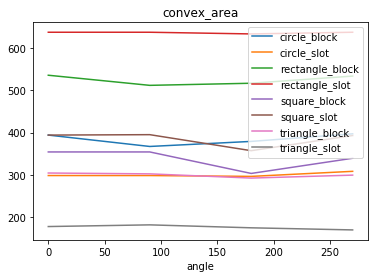

In [62]:
plot_feature('convex_area')

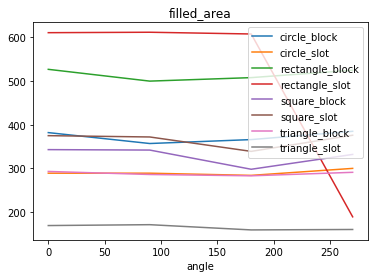

In [63]:
plot_feature('filled_area')

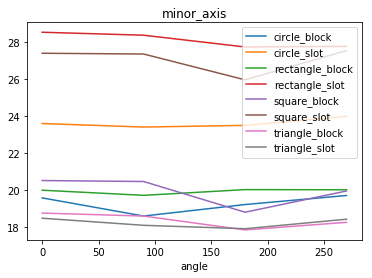

In [64]:
plot_feature('minor_axis')

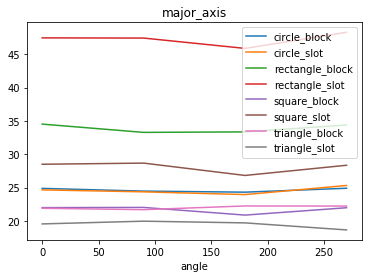

In [65]:
plot_feature('major_axis')

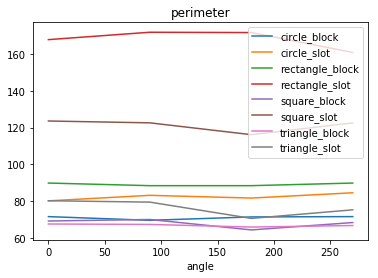

In [66]:
plot_feature('perimeter')

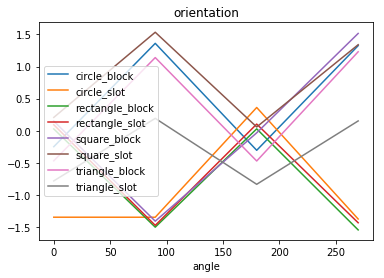

In [67]:
plot_feature('orientation')

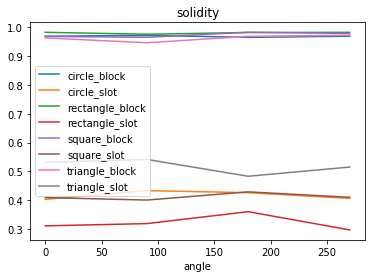

In [68]:
plot_feature('solidity')

# Classification

In [25]:
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.ensemble
import sklearn.svm

model = sklearn.naive_bayes.GaussianNB(priors=np.ones(8)/8)

INPUT_FEATURES = ['minor_axis', 'major_axis', 'area', 'convex_area', 'perimeter', 'solidity', 'filled_area', 'eccentricity']

In [26]:
features = []
for feature_name in INPUT_FEATURES:
    features.append(training_set[feature_name])
    
features = np.array(features).transpose()

labels = np.array(training_set['label'])

In [27]:
model.fit(features, labels)

GaussianNB(priors=array([0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]),
      var_smoothing=1e-09)

In [82]:
from scipy.stats import norm

for feature_index, feature_name in enumerate(INPUT_FEATURES):  
    x_range = np.arange(training_set[feature_name].min(), training_set[feature_name].max(), 0.001)
  
    for class_index, class_name in enumerate(model.classes_):
        ax = plt.plot(
            x_range, 
            norm.pdf(x_range, model.theta_[class_index][feature_index],model.sigma_[class_index][feature_index]),
            label=class_name
        )
    plt.title(feature_name)
    plt.xlabel('X')
    plt.ylabel('P(X)')
    plt.legend()
    plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'theta_'

In [83]:
model.class_prior_ 

AttributeError: 'LogisticRegression' object has no attribute 'class_prior_'

In [134]:
samples = np.array([
    region_stats['minor_axis'],
    region_stats['major_axis'],
    region_stats['area'],
    region_stats['convex_area'],
    region_stats['perimeter'],
    region_stats['solidity']
]).transpose()
model.predict_proba(samples)

ValueError: Number of features of the model must match the input. Model n_features is 8 and input n_features is 6 

# Inference

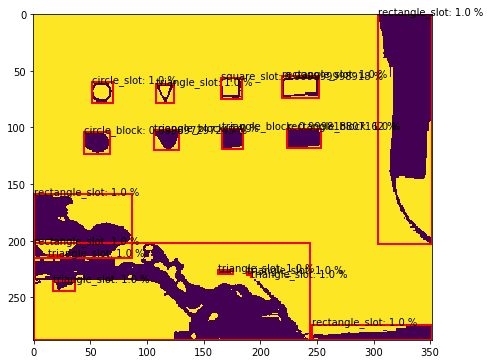

In [28]:
frame = np.load('../images/sample-1.npy')
gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
threshold = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)[1] / 255
labeled_image = label(threshold, background=1)
regions =  regionprops(labeled_image)
region_stats = pd.DataFrame()
for r in regions:
    region = parse_region(r)
    region_stats = region_stats.append(region, ignore_index=True)

region_stats

features = []
for feature_name in INPUT_FEATURES:
    features.append(region_stats[feature_name])
    
features = np.array(features).transpose()
predictions = model.predict_proba(features)


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(threshold)

p = []

for index, prediction in enumerate(predictions):
    minr, minc, maxr, maxc = regions[index].bbox
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                              fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
    p.append([model.classes_[prediction.argmax()], prediction.max()])
    ax.annotate('{}: {} %'.format(model.classes_[prediction.argmax()], prediction.max()), (minc, minr))
    
plt.show()


In [29]:
import pickle

with open('object_detector.model', 'w+') as f:
    pickle.dump(model, f)
    f.flush()

In [ ]:
predictions

In [41]:
training_set.describe()

,angle,area,convex_area,filled_area,major_axis,minor_axis,orientation,perimeter,scale,solidity
count,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000,1429.000000
mean,179.066480,263.602519,393.537439,323.605318,27.886374,21.809900,-0.019442,93.220701,0.037490,0.678598
std,103.750261,135.570246,136.539821,125.646411,8.610795,3.649353,0.915998,28.967800,0.007205,0.274321
min,0.000000,78.000000,145.000000,79.000000,17.954514,16.481270,-1.570178,61.662951,0.025014,0.284866
25%,90.000000,138.000000,313.000000,276.000000,21.864272,19.013911,-0.837250,72.083261,0.031353,0.401929
50%,178.000000,278.000000,371.000000,324.000000,24.850092,19.959566,-0.037481,80.591883,0.037660,0.906061
75%,268.000000,358.000000,420.000000,378.000000,29.027514,24.538182,0.791593,97.562446,0.043714,0.945155
max,358.000000,537.000000,682.000000,629.000000,49.389326,28.720263,1.566565,178.006097,0.049955,0.984615


In [42]:
INPUT_FEATURES

['minor_axis', 'major_axis', 'area', 'convex_area', 'perimeter', 'solidity']

In [43]:
model.class_prior_

array([0.12596221, 0.12596221, 0.12596221, 0.1196641 , 0.12596221,
       0.12456263, 0.12596221, 0.12596221])